In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.tree import export_graphviz
from IPython.display import Image

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [272]:
df = pd.read_csv('data/final_df.csv')

In [273]:
df = df.iloc[:,1:]

In [274]:
y = df.churn
X = df.drop('churn', axis = 1)

In [275]:
mm = MinMaxScaler()
scaled_df = pd.DataFrame(mm.fit_transform(X), columns = X.columns)
scaled_df.head()

,seniorcitizen,tenure,monthlycharges,totalcharges,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,...,streamingmovies_Yes,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,0.0,0.013889,0.115423,0.003437,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.472222,0.385075,0.217564,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.027778,0.354229,0.012453,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.625000,0.239303,0.211951,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.027778,0.521891,0.017462,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [276]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 33)

# **1) Vanilla Decision Tree Classifier**

In [277]:
clf1 = DecisionTreeClassifier(random_state = 33)
clf1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=33, splitter='best')

In [278]:
test_preds1 = clf1.predict(X_test)

In [279]:
# Calculate and print all four major metrics
print(f"Precision Score: {precision_score(y_test, test_preds1)}")
print(f"Recall Score: {recall_score(y_test, test_preds1)}")
print(f"Accuracy Score: {accuracy_score(y_test, test_preds1)}")
print(f"F1 Score: {f1_score(y_test, test_preds1)}")

Precision Score: 0.4922048997772829
Recall Score: 0.46041666666666664
Accuracy Score: 0.7234525837592277
F1 Score: 0.47578040904198066


AUC Score: 0.6412153590944575


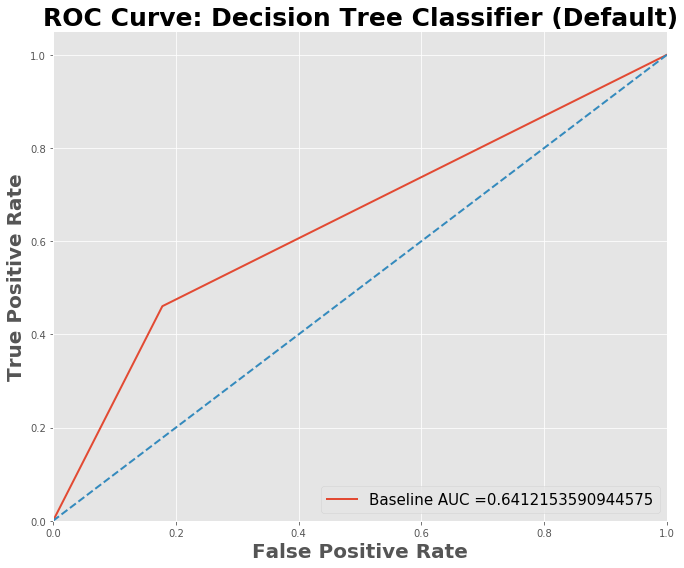

In [280]:
fpr, tpr, threshold = roc_curve(y_test, test_preds1)
# Calculate AUC score from sklearn.metrics library
roc_auc = auc(fpr, tpr)
# Print auc score
print(f'AUC Score: {roc_auc}')

# Plot AUC curve
plt.style.use('ggplot')
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, lw = 2, label = 'Baseline AUC ='+str(roc_auc))
plt.plot([0,1],[0,1], linestyle = '--', lw = 2)
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate', fontsize = 20, fontweight = 'bold')
plt.ylabel('True Positive Rate', fontsize = 20, fontweight = 'bold')
plt.title('ROC Curve: Decision Tree Classifier (Default)', fontsize = 25, fontweight = 'bold')
plt.legend(loc = 4, fontsize = 15)
plt.tight_layout()

In [281]:
pd.crosstab(y_test, test_preds1, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0,1,All
True,,,
0,1053,228,1281
1,259,221,480
All,1312,449,1761


# **2) GridSearchCV Classifier**

In [282]:
clf3 = DecisionTreeClassifier(random_state = 33)
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'min_samples_split':[20, 25, 30, 35, 40],
    'min_samples_leaf':[1,2,3,4,5,6]
}
gs_tree = GridSearchCV(clf3, param_grid, cv = 4, verbose = True)
gs_tree.fit(X_train, y_train)

Fitting 4 folds for each of 720 candidates, totalling 2880 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed:   56.6s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=33,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15,
  

In [283]:
print(f"Best Parameters: {gs_tree.best_params_}")
print(f"Best Score: {gs_tree.best_score_}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 30}
Best Score: 0.7942067398712609


# GridSearchCV Decision Tree Model

In [284]:
final_clf = DecisionTreeClassifier(
    criterion = 'entropy',
    max_depth = 6,
    min_samples_leaf = 1,
    min_samples_split = 30,
    random_state = 33)
final_clf.fit(X_train, y_train)
test_preds2 = final_clf.predict(X_test)

In [285]:
# Print 4 major metrics
print(f"Precision Score: {precision_score(y_test, test_preds2)}")
print(f"Recall Score: {recall_score(y_test, test_preds2)}")
print(f"Accuracy Score: {accuracy_score(y_test, test_preds2)}")
print(f"F1 Score: {f1_score(y_test, test_preds2)}")

Precision Score: 0.628992628992629
Recall Score: 0.5333333333333333
Accuracy Score: 0.787052810902896
F1 Score: 0.5772266065388951


AUC Score: 0.7077283372365338


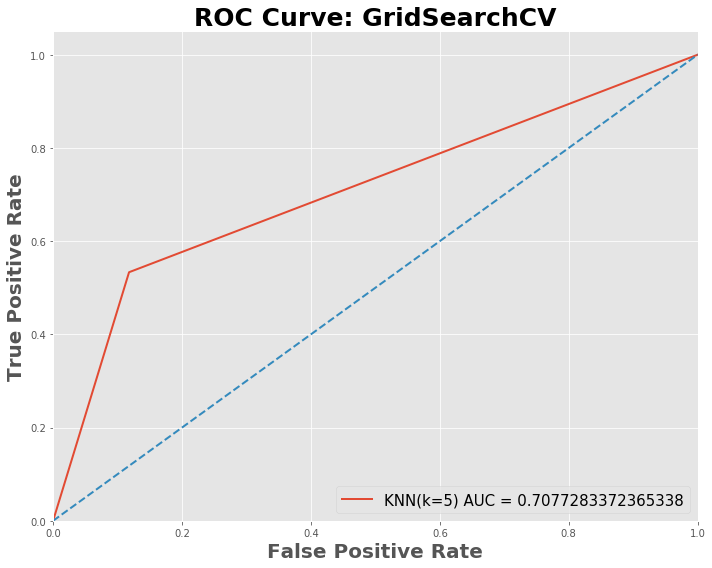

In [286]:
fpr, tpr, threshold = roc_curve(y_test, test_preds2)
roc_auc = auc(fpr, tpr)
print(f'AUC Score: {roc_auc}')

plt.style.use('ggplot')
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr,lw = 2, label = 'KNN(k=5) AUC = '+str(roc_auc))
plt.plot([0,1],[0,1], linestyle = '--', lw = 2)
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate', fontsize = 20, fontweight = 'bold')
plt.ylabel('True Positive Rate', fontsize = 20, fontweight = 'bold')
plt.title('ROC Curve: GridSearchCV', fontsize = 25, fontweight = 'bold')
plt.legend(loc = 4, fontsize = 15)
plt.tight_layout()

In [287]:
pd.crosstab(y_test, test_preds2, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0,1,All
True,,,
0,1130,151,1281
1,224,256,480
All,1354,407,1761


# **2) Vanilla Classifier: Manual Pruning**

## Max Depth

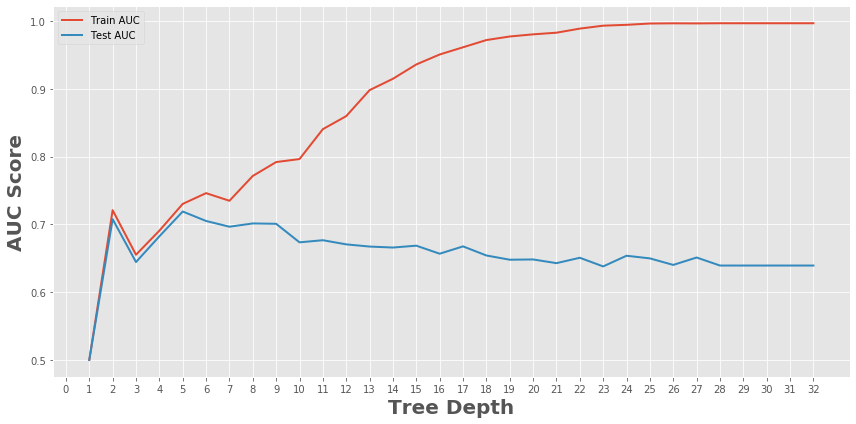

In [288]:
max_depths = np.linspace(1,32,32,endpoint = True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = max_depth, random_state = 33)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
plt.figure(figsize = (12, 6))
plt.plot(max_depths, train_results, label = 'Train AUC', lw = 2)
plt.plot(max_depths, test_results, label = 'Test AUC', lw = 2)
plt.ylabel('AUC Score', fontsize = 20, fontweight = 'bold')
plt.xticks(np.arange(0,33))
plt.xlabel('Tree Depth', fontsize = 20, fontweight = 'bold')
plt.legend()
plt.tight_layout()

 - Training error decreases with tree depth (a sign of overfitting as tree depth increases)
 - Test error increases after depth = 3 (some fluctuations, not stable)
 - Training and Test errors rise rapidly between depths of 3 & 4
 - **Optimal value roughly 2/3**

## Minimum Sample Split
- Minimum number of samples required to split an internal node
- As number increases, tree becomes more constrained as it has to consider more samples @ node

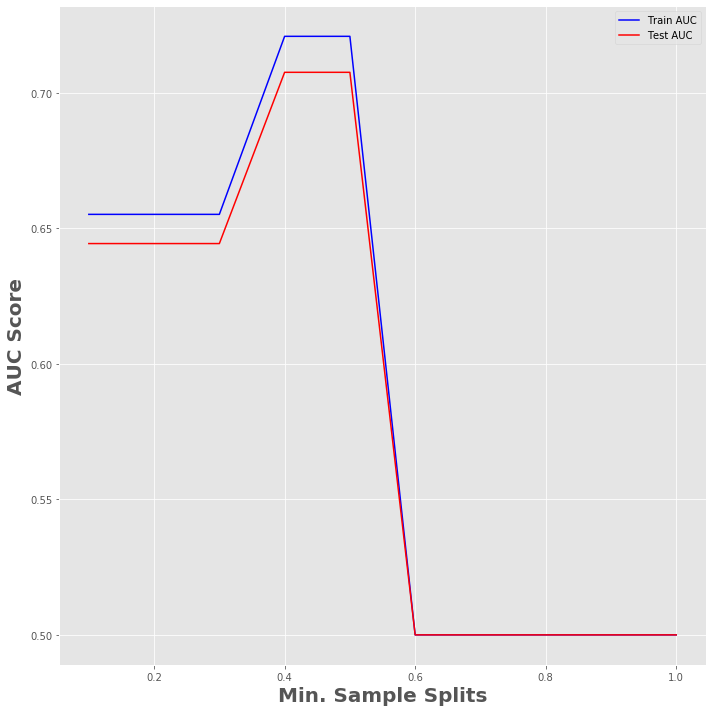

In [289]:
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint = True)
train_results = []
test_results = []
for min_split in min_samples_split:
    dt = DecisionTreeClassifier('entropy', min_samples_split = min_split, random_state = 33)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    fpr, tpr, threshold = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    test_pred = dt.predict(X_test)
    fpr, tpr, threshold = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
plt.figure(figsize = (10, 10))
plt.plot(min_samples_split, train_results, 'b', label = 'Train AUC')
plt.plot(min_samples_split, test_results, 'r', label = 'Test AUC')
plt.xlabel('Min. Sample Splits', fontweight = 'bold', fontsize = 20)
plt.ylabel('AUC Score', fontweight = 'bold', fontsize = 20)
plt.title('')
plt.legend()
plt.tight_layout()

In [290]:
# Min Samples Split both train and test both begin to stabilize at min_samples_split = 33
# Further increase in min_sample_split will not increase learning ability

## Min Samples Leaf
- Identify min. number of samples that we want a leaf node to contain
- When min. size is achieved at a node, it does not get split any further
- Too many samples in leaf node indicate high level of uncertainty in data

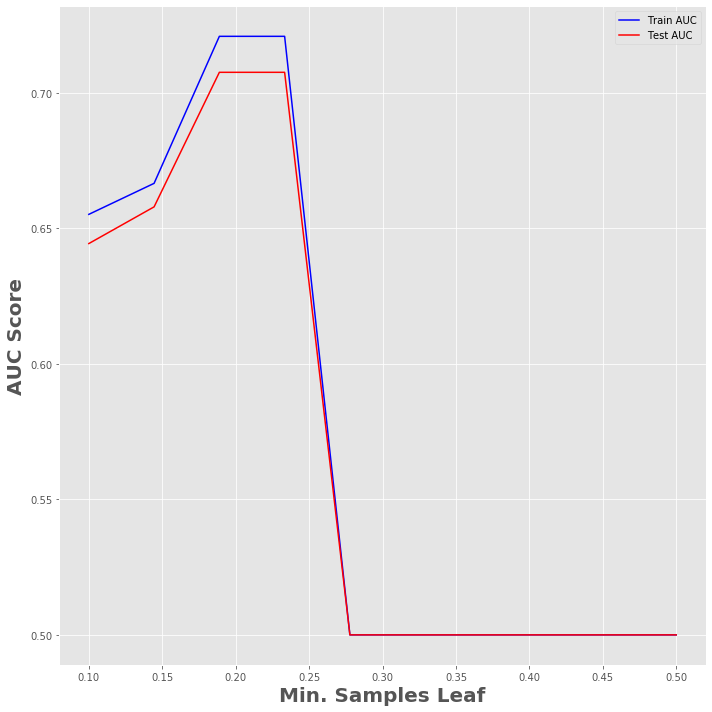

In [291]:
min_samples_leaf = np.linspace(0.1, 0.5, 10, endpoint = True)
train_results = []
test_results = []
for min_leaf in min_samples_leaf:
    dt = DecisionTreeClassifier('entropy', min_samples_leaf = min_leaf, random_state = 33)
    dt.fit(X_train, y_train)
    train_preds = dt.predict(X_train)
    fpr, tpr, threshold = roc_curve(y_train, train_preds)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    test_preds = dt.predict(X_test)
    fpr, tpr, threshold = roc_curve(y_test, test_preds)
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
plt.figure(figsize = (10,10))
plt.plot(min_samples_leaf, train_results, 'b', label = 'Train AUC')
plt.plot(min_samples_leaf, test_results, 'r', label = 'Test AUC')
plt.xlabel('Min. Samples Leaf', fontweight = 'bold', fontsize = 20)
plt.ylabel('AUC Score', fontweight = 'bold', fontsize = 20)
plt.legend()
plt.tight_layout()

- **Accuracy decreases significantly after 0.23 for both test and train**

## Maximum Features

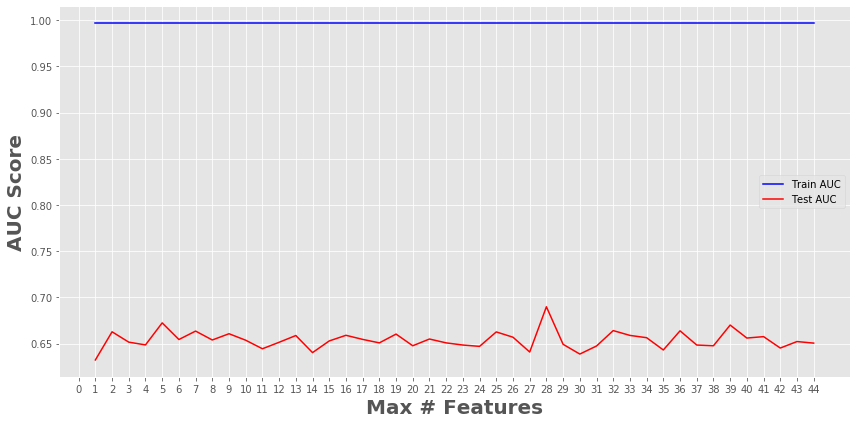

In [292]:
max_features = list(range(1, X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier('entropy', max_features = max_feature, random_state = 33)
    dt.fit(X_train, y_train)
    train_preds = dt.predict(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_preds)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    test_preds = dt.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, test_preds)
    roc_auc = auc(fpr, tpr)
    test_results.append(roc_auc)
    
plt.figure(figsize = (12,6))
plt.plot(max_features, train_results, 'b', label = 'Train AUC')
plt.plot(max_features, test_results, 'r', label = 'Test AUC')
plt.xlabel('Max # Features', fontweight = 'bold', fontsize = 20)
plt.xticks(np.arange(0, 45))
plt.ylabel('AUC Score', fontweight = 'bold', fontsize = 20)
plt.legend()
plt.tight_layout()

- No clear effect on training (flat AUC)
- Multiple fluctuations in test AUC but not definitive
- Highest AUC value is 28

# **3) Manual Pruning Classifier Model**

In [293]:
dt2 = DecisionTreeClassifier(
                            criterion = 'entropy',
                            max_depth = 3,
                            min_samples_split = 0.4,
                            min_samples_leaf = 0.23,
                            random_state = 33)
dt2.fit(X_train, y_train)
y_preds = dt2.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)
roc_auc

0.7076258782201404

In [294]:
print(f"Precision Score: {precision_score(y_test, y_preds)}")
print(f"Recall Score: {recall_score(y_test, y_preds)}")
print(f"Accuracy Score: {accuracy_score(y_test, y_preds)}")
print(f"F1 Score: {f1_score(y_test, y_preds)}")

Precision Score: 0.5451127819548872
Recall Score: 0.6041666666666666
Accuracy Score: 0.7546848381601363
F1 Score: 0.5731225296442688


AUC Score: 0.7076258782201404


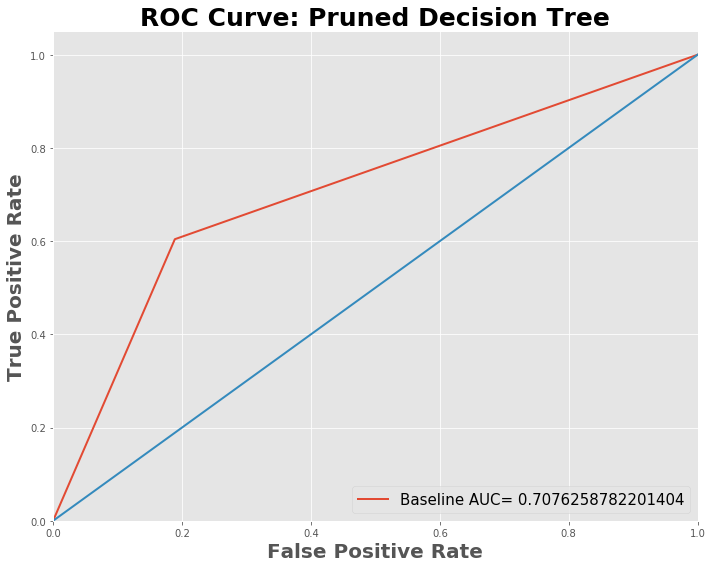

In [295]:
print(f'AUC Score: {roc_auc}')
plt.figure(figsize = (10, 8))
plt.plot(fpr, tpr, lw = 2, label = 'Baseline AUC= ' + str(roc_auc))
plt.plot([0,1], [0,1], lw = 2)
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate', fontweight = 'bold', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20, fontweight = 'bold')
plt.title('ROC Curve: Pruned Decision Tree', fontweight = 'bold', fontsize = 25)
plt.legend(loc = 4, fontsize = 15)
plt.tight_layout()

In [296]:
pd.crosstab(y_test, y_preds, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0,1,All
True,,,
0,1039,242,1281
1,190,290,480
All,1229,532,1761
